In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Court Position and Shot Type Analysis

In [4]:
data = pd.read_csv('../data.csv')
data = data[data.shot_made_flag.notnull()].reset_index()
features = ['combined_shot_type', 'period', 'playoffs', 'seconds_remaining', 'minutes_remaining', 'season',
            'shot_distance', 'shot_made_flag', 'shot_zone_area',
            'game_date', 'matchup', 'loc_x', 'loc_y', 'action_type']
dataset = data[features]

In [5]:
dataset['total_seconds_remaining'] = 60 * \
    dataset['minutes_remaining'] + dataset['seconds_remaining']
dataset.drop('minutes_remaining', axis=1, inplace=True)
dataset.drop('seconds_remaining', axis=1, inplace=True)
dataset['month'] = dataset['game_date'].map(lambda x: x.split('-')[1])
dataset.drop('game_date', axis=1, inplace=True)
dataset['home'] = dataset['matchup'].str.contains('vs').astype('int')
dataset.drop('matchup', axis=1, inplace=True)

### Visualising the difference between successful and unsuccessful shots, broken down by shot type. Many more unsuccessful shots than successful ones! Successful shots taken from less far away, and possibly more tightly focused on those hotspots. Additionally some types of shots clearly dominate more than others, almost all jump shots and layups.

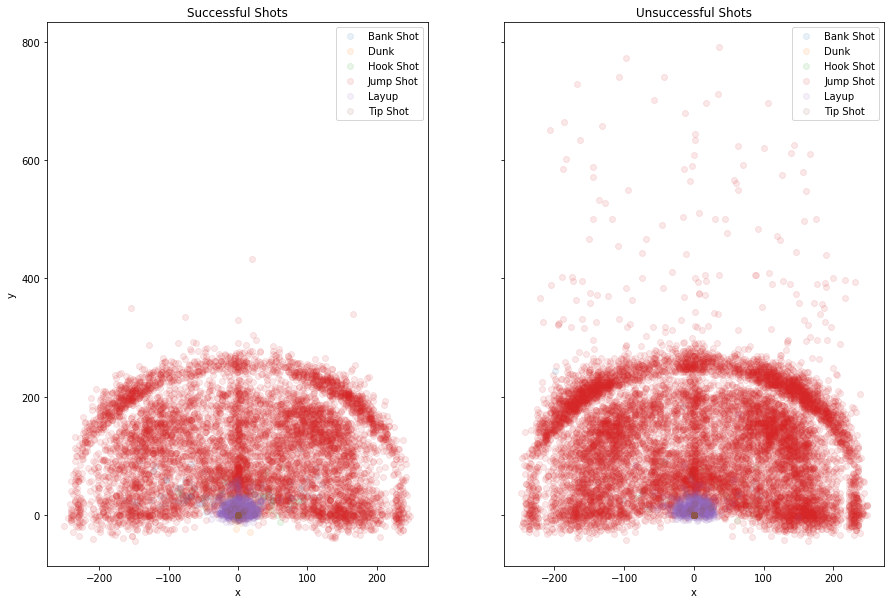

In [6]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 10))

shots_made = dataset[dataset['shot_made_flag'] == 1]
shots_not_made = dataset[dataset['shot_made_flag'] == 0]

groups = shots_made.groupby('combined_shot_type')
for name, group in groups:
    ax[0].plot(group.loc_x, group.loc_y, label=name,
               marker='o', linestyle='', alpha=0.1)


groups = shots_not_made.groupby('combined_shot_type')
for name, group in groups:
    ax[1].plot(group.loc_x, group.loc_y, label=name,
               marker='o', linestyle='', alpha=0.1)

ax[0].set_ylabel('y')
ax[0].set_xlabel('x')
ax[0].set_title('Successful Shots')
ax[1].set_title('Unsuccessful Shots')
ax[1].set_xlabel('x')
ax[0].legend()
ax[1].legend()
plt.show()

## Post Shot Analysis

In [7]:
sorted_games = data.copy()
sorted_games = sorted_games.sort_values(['game_date', 'period', 'seconds_remaining'], ascending=[
    True, True, False]).reset_index(drop=True)

In [8]:
def different_period(row):
    if row.previous_game_date != row.game_date or row.previous_period != row.period:
        return 0
    return row.made_previous_shot

In [9]:
sorted_games['made_previous_shot'] = sorted_games['shot_made_flag'].shift(
    1).fillna(value=0)
sorted_games['previous_period'] = sorted_games['period'].shift(
    1).fillna(value=0)
sorted_games['previous_game_date'] = sorted_games['game_date'].shift(
    1).fillna(value=0)
sorted_games['previous_shot_distance'] = sorted_games['shot_distance'].shift(
    1).fillna(value=0)
sorted_games['made_previous_shot'] = sorted_games.apply(
    different_period, axis=1)
sorted_games.drop(columns=['previous_period',
                           'previous_game_date'], inplace=True)

In [10]:
dist_diff_after_missing = (sorted_games[sorted_games.made_previous_shot == 0]['shot_distance'] -
                           sorted_games[sorted_games.made_previous_shot == 0]['previous_shot_distance'])

In [11]:
dist_diff_after_hitting = (sorted_games[sorted_games.made_previous_shot == 1]['shot_distance'] -
                           sorted_games[sorted_games.made_previous_shot == 1]['previous_shot_distance'])

## 

[(0, 0.07), (-40, 40)]

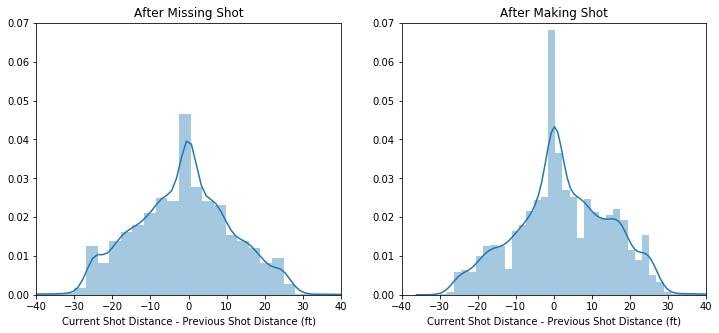

In [12]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("After Missing Shot")
plt.xlabel("Current Shot Distance - Previous Shot Distance (ft)")
sns.distplot(dist_diff_after_missing).set(xlim=(-40, 40), ylim=(0, 0.07))
plt.subplot(122)
plt.title("After Making Shot")
plt.xlabel("Current Shot Distance - Previous Shot Distance (ft)")
sns.distplot(dist_diff_after_hitting).set(xlim=(-40, 40), ylim=(0, 0.07))